<a href="https://colab.research.google.com/github/christine127/Portfolio_Recommendation_Project/blob/main/%ED%81%B4%EB%9F%AC%EC%8A%A4%ED%84%B0%EB%A7%81_%EC%8B%9C%EB%8F%841_Robust.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, RobustScaler, Normalizer, StandardScaler
from sklearn.model_selection import cross_validate, KFold, train_test_split, cross_val_score
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans, SpectralClustering
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from tqdm import tqdm
import tensorflow as tf
# import xgboost
# import lightgbm
import pickle
from yellowbrick.cluster import KElbowVisualizer

import keras
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier

import matplotlib.pyplot as plt

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
print(tf.config.list_physical_devices('GPU'))

# Tab키 사용
%config Completer.use_jedi = False

path = '/content/drive/MyDrive/소회의실 프로젝트/전처리_완료/'



/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


[]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: UserWarning: Config option `use_jedi` not recognized by `IPCompleter`.


In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
plt.rc('font', family='NanumBarunGothic')

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 40 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 2s (5,632 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 160837 files and d

In [ ]:
# temp = pd.read_csv(path + 'customer_info_brif_코스피코스닥합체.csv')
# #                    , encoding='cp949')

temp = pd.read_csv(path + 'customer_info_공모주수정.csv'
                   , encoding='cp949')

In [ ]:
temp.info()
temp.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24235 entries, 0 to 24234
Data columns (total 57 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   고객구분코드             24235 non-null  object 
 1   고객성별구분코드           24235 non-null  int64  
 2   동일나이군구분코드          24235 non-null  int64  
 3   주소                 24235 non-null  object 
 4   상품개수               24235 non-null  int64  
 5   총매수금액              24235 non-null  float64
 6   총매수수량              24235 non-null  float64
 7   kosdaq_cap         24235 non-null  float64
 8   large_cap          24235 non-null  float64
 9   medium_cap         24235 non-null  float64
 10  small_cap          24235 non-null  float64
 11  large_cap_period   24235 non-null  float64
 12  medium_cap_period  24235 non-null  float64
 13  small_cap_period   24235 non-null  float64
 14  kosdaq_cap_period  24235 non-null  float64
 15  수익률                24235 non-null  float64
 16  업종개수               242

,고객구분코드,고객성별구분코드,동일나이군구분코드,주소,상품개수,총매수금액,총매수수량,kosdaq_cap,large_cap,medium_cap,small_cap,large_cap_period,medium_cap_period,small_cap_period,kosdaq_cap_period,수익률,업종개수,상하한가여부,kosdaq_cap_PER,large_cap_PER,medium_cap_PER,small_cap_PER,kosdaq_cap_PBR,large_cap_PBR,medium_cap_PBR,small_cap_PBR,kosdaq_cap_ROE,large_cap_ROE,medium_cap_ROE,small_cap_ROE,kosdaq_cap_EPS,large_cap_EPS,medium_cap_EPS,small_cap_EPS,kosdaq_cap_DIV,large_cap_DIV,medium_cap_DIV,small_cap_DIV,매도매수일치_외국인,매도매수일치_기관,kosdaq_cap_TR,large_cap_TR,medium_cap_TR,small_cap_TR,kosdaq_cap_ATR_7,large_cap_ATR_7,medium_cap_ATR_7,small_cap_ATR_7,kosdaq_cap_ATR_14,large_cap_ATR_14,medium_cap_ATR_14,small_cap_ATR_14,시간대_1,시간대_2,시간대_3,시간대_4,new_stock_rate
0,A0001,1,30,경기,149,69911181.0,25198.0,0.778486,0.009521,0.024741,0.187252,41.666667,23.0,26.757143,24.744604,-6.270472,41,0.060686,27.887566,0.042919,5.187663,5.054957,2.611845,0.027131,0.057036,0.346354,17.546684,0.080979,2.272339,5.202635,112.028066,10.432437,1.271845,17.660563,0.378953,0.008371,0.000000,0.109937,0.452507,0.414248,1329.754671,124.893756,38.941099,145.776334,892.142308,84.398292,28.399460,106.532121,760.492888,56.763238,26.986746,88.054554,0.270449,0.354881,0.372032,0.002639,0.001191
1,A00010,1,20,경남,10,725350.0,366.0,0.679107,0.000000,0.075550,0.245344,0.000000,69.0,44.750000,38.833333,-19.434190,10,0.000000,0.600995,0.000000,0.000000,0.782520,6.049455,0.000000,0.000000,0.408959,0.858564,0.000000,0.000000,0.411072,23.622286,0.000000,0.000000,29.011071,0.091639,0.000000,0.000000,0.085899,0.333333,0.133333,1233.937025,0.000000,185.096850,111.724202,661.828441,0.000000,124.117421,65.465677,675.757230,0.000000,126.275985,71.574031,0.266667,0.600000,0.133333,0.000000,0.000000
2,A000100,2,40,서울,10,12100965.0,602.0,0.452763,0.289233,0.258003,0.000000,42.000000,31.0,0.000000,43.250000,-15.747394,8,0.000000,65.308432,6.810614,75.794536,0.000000,5.252630,1.216432,0.811280,0.000000,3.825495,2.155547,25.809108,0.000000,298.658330,4306.144179,2071.804703,0.000000,0.000000,0.764815,0.112839,0.000000,0.357143,0.357143,9586.881480,7243.223991,1239.226388,0.000000,4003.172993,12115.326576,1448.517433,0.000000,3331.930879,10686.278798,1030.427488,0.000000,0.857143,0.142857,0.000000,0.000000,0.000000
3,A0001000,1,30,광주,6,1223372.0,197.0,0.747271,0.000000,0.000000,0.252729,0.000000,0.0,8.000000,1.000000,-8.447806,5,0.000000,0.000000,0.000000,0.000000,0.458963,5.051621,0.000000,0.000000,0.318110,0.000000,0.000000,0.000000,2.187843,0.000000,0.000000,0.000000,84.750759,0.000000,0.000000,0.000000,0.163561,0.454545,0.363636,2929.730068,0.000000,0.000000,148.238009,4131.864672,0.000000,0.000000,120.307944,3508.727175,0.000000,0.000000,117.984712,0.090909,0.272727,0.636364,0.000000,0.000000
4,A00010000,1,20,경기,12,17936233.0,3683.0,0.363163,0.515705,0.093949,0.027182,15.750000,0.0,25.000000,16.000000,-0.571468,10,0.000000,0.518449,3.621221,0.000000,0.000000,4.361157,0.669548,2.443626,0.007908,0.540051,2.629404,0.000000,0.000000,59.090117,3103.011998,0.000000,0.000000,0.068295,1.403069,0.000000,0.000000,0.407407,0.518519,1457.983417,1344.542450,338.218175,1.320072,1132.187910,1325.769984,263.998076,1.020217,980.226151,1161.921031,185.348929,1.468851,0.333333,0.333333,0.333333,0.000000,0.000000


In [ ]:
num_temp = temp.select_dtypes(include = ['int','float'])

In [ ]:
num_temp.shape

(7938, 21)

In [ ]:
num_temp.head()

,고객성별구분코드,동일나이군구분코드,총매수금액,총매수수량,수익률,업종개수,상하한가여부,매도매수일치_외국인,매도매수일치_기관,large_cap,medium_cap,small_cap,large_cap_period,medium_cap_period,small_cap_period,PER,PBR,ROE,EPS,DIV,ATR_7
0,2,30,1691500.0,19.0,-2.483187,2,0.000000,0.250000,0.250000,1.000000,0.000000,0.000000,5.5,0.000000,0.000000,7.588331,0.703141,14.978474,13138.000591,1.907657,6845.289473
1,2,30,18044560.0,588.0,-2.593365,3,0.350000,0.350000,0.400000,0.805578,0.194422,0.000000,5.6,11.500000,0.000000,118.408418,8.193013,12.176953,856.703595,0.101752,7372.020518
2,2,50,195560.0,23.0,-14.143997,1,0.000000,0.100000,0.200000,0.000000,1.000000,0.000000,0.0,25.933333,0.000000,1.396000,0.696500,2.005266,6032.000000,3.646500,515.642857
3,1,30,20627310.0,4558.0,2.291601,15,0.035714,0.464286,0.464286,0.000000,0.437730,0.562270,0.0,7.600000,10.333333,20.328912,0.800545,17.152872,283.279906,0.621850,460.803372
4,1,20,1128091.0,1797.0,2.535725,6,0.000000,0.454545,0.545455,0.324974,0.000000,0.675026,0.0,0.000000,8.714286,2.883263,0.604482,2.487257,694.305208,0.246067,154.412290


In [ ]:
num_temp = pd.DataFrame(columns = list(num_temp), data = RobustScaler().fit_transform(num_temp))
# num_temp.drop('DIV', axis= 1, inplace = True)

,고객성별구분코드,동일나이군구분코드,총매수금액,총매수수량,업종개수,매도매수일치_기관,large_cap,medium_cap,small_cap,large_cap_period,PER,PBR,ROE,EPS,DIV,ATR_7
0,1.0,0.0,-0.188454,-0.220015,-0.8,-1.166667,0.798295,-0.550775,-0.356546,-0.391667,-0.137600,-0.399572,1.284474,4.487079,1.061720,2.107561
1,1.0,0.0,1.012451,0.214668,-0.6,-0.266667,0.520765,-0.066435,-0.356546,-0.386667,4.516943,3.510591,0.905693,0.058723,-0.373672,2.319570
2,1.0,1.0,-0.298310,-0.216960,-1.0,-1.466667,-0.629170,1.940399,-0.356546,-0.666667,-0.397684,-0.403039,-0.469574,1.924817,2.443808,-0.440116
3,0.0,0.0,1.202118,3.247517,1.8,0.119048,-0.629170,0.539688,0.959189,-0.666667,0.397516,-0.348721,1.578465,-0.148041,0.039718,-0.462189
4,0.0,-0.5,-0.229829,1.138273,0.0,0.606061,-0.165281,-0.550775,1.223045,-0.666667,-0.335217,-0.451078,-0.404407,0.000165,-0.258966,-0.585511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7933,0.0,0.0,0.207308,3.671505,-0.2,0.060606,0.261436,-0.152156,0.149091,0.283333,-0.028248,-0.551939,1.174691,0.358817,0.523108,0.316181
7934,0.0,-0.5,6.608258,3.763178,0.0,0.333333,-0.418166,-0.199783,1.307901,0.233333,-0.056973,0.632808,-0.211370,-0.200899,-0.304566,0.325801
7935,0.0,-0.5,-0.273831,-0.227655,-0.8,-1.666667,0.690608,-0.362841,-0.356546,0.197470,0.131442,-0.413144,1.513316,2.317100,2.591976,1.925226
7936,0.0,0.0,-0.256647,-0.223835,-0.6,-0.666667,0.611933,-0.225541,-0.356546,-0.216667,-0.232764,-0.340779,0.234008,2.383798,2.046397,0.863129


In [ ]:
# threshold = 0.8
# corr_df = num_temp.corr()
# corr_df = np.triu(corr_df,1)
# corr_df = pd.DataFrame(corr_df)
# temp_index = list(set(np.where(corr_df >= threshold)[0].tolist() + np.where(corr_df >= threshold)[1].tolist()))
# temp = num_temp[num_temp.columns[temp_index]]
# corr_df.iloc[temp_index, temp_index]
# temp

In [ ]:
# import matplotlib.pyplot as plt
# import matplotlib
# matplotlib.font_manager._rebuild()

# temp_len = len(list(num_temp))
# temp_range = int(temp_len/5)

# for i in range(0,20,4):
#     print(num_temp.columns.tolist()[i:i+temp_range])
#     plt.figure(figsize= (20,4))
#     plt.boxplot([num_temp['{}'.format(i)] for i in num_temp.columns.tolist()[i:i+temp_range]])
#     plt.xticks([1, 2, 3, 4], num_temp.columns.tolist()[i:i+temp_range])
#     plt.show()

# 첫번째 검정

In [ ]:
# model = KMeans()
# visualizer = KElbowVisualizer(model, size=(1800, 500))
# visualizer.fit(num_temp)
# visualizer.show()

k = 5
kmeans = KMeans(n_clusters= k, random_state=0).fit(num_temp)

train_cluster = pd.DataFrame(columns = list(num_temp), data = num_temp)
train_cluster['cluster'] = kmeans.predict(num_temp)

ValueError: ignored

In [ ]:
train_cluster.cluster.value_counts()

0    6422
4     764
3     599
2     129
1      24
Name: cluster, dtype: int64

In [ ]:
train_y = train_cluster.cluster
scl_train = train_cluster.drop('cluster', axis = 1)

In [ ]:
scl_train

,고객성별구분코드,동일나이군구분코드,총매수금액,총매수수량,수익률,업종개수,상하한가여부,매도매수일치_외국인,매도매수일치_기관,large_cap,medium_cap,small_cap,large_cap_period,medium_cap_period,small_cap_period,PER,PBR,ROE,EPS,DIV,ATR_7
0,1.0,0.0,-0.188454,-0.220015,-0.064314,-0.8,0.000000,-0.952381,-1.166667,0.798295,-0.550775,-0.356546,-0.391667,-0.602899,-0.481885,-0.137600,-0.399572,1.284474,4.487079,1.061720,2.107561
1,1.0,0.0,1.012451,0.214668,-0.073701,-0.6,3.850000,-0.419048,-0.266667,0.520765,-0.066435,-0.356546,-0.386667,0.063768,-0.481885,4.516943,3.510591,0.905693,0.058723,-0.373672,2.319570
2,1.0,1.0,-0.298310,-0.216960,-1.057815,-1.0,0.000000,-1.752381,-1.466667,-0.629170,1.940399,-0.356546,-0.666667,0.900483,-0.481885,-0.397684,-0.403039,-0.469574,1.924817,2.443808,-0.440116
3,0.0,0.0,1.202118,3.247517,0.342498,1.8,0.392857,0.190476,0.119048,-0.629170,0.539688,0.959189,-0.666667,-0.162319,0.071390,0.397516,-0.348721,1.578465,-0.148041,0.039718,-0.462189
4,0.0,-0.5,-0.229829,1.138273,0.363297,0.0,0.000000,0.138528,0.606061,-0.165281,-0.550775,1.223045,-0.666667,-0.602899,-0.015298,-0.335217,-0.451078,-0.404407,0.000165,-0.258966,-0.585511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7933,0.0,0.0,0.207308,3.671505,0.903569,-0.2,1.000000,-0.831169,0.060606,0.261436,-0.152156,0.149091,0.283333,0.092754,0.368243,-0.028248,-0.551939,1.174691,0.358817,0.523108,0.316181
7934,0.0,-0.5,6.608258,3.763178,0.353135,0.0,1.222222,0.282187,0.333333,-0.418166,-0.199783,1.307901,0.233333,0.405797,-0.410494,-0.056973,0.632808,-0.211370,-0.200899,-0.304566,0.325801
7935,0.0,-0.5,-0.273831,-0.227655,-0.461050,-0.8,0.000000,-0.507937,-1.666667,0.690608,-0.362841,-0.356546,0.197470,-0.544928,-0.481885,0.131442,-0.413144,1.513316,2.317100,2.591976,1.925226
7936,0.0,0.0,-0.256647,-0.223835,0.453254,-0.6,0.000000,-1.396825,-0.666667,0.611933,-0.225541,-0.356546,-0.216667,0.291533,-0.481885,-0.232764,-0.340779,0.234008,2.383798,2.046397,0.863129


In [ ]:
temp_list

['고객성별구분코드',
 '동일나이군구분코드',
 '총매수금액',
 '총매수수량',
 '업종개수',
 '매도매수일치_기관',
 'large_cap',
 'medium_cap',
 'small_cap',
 'large_cap_period',
 'PER',
 'PBR',
 'ROE',
 'EPS',
 'DIV',
 'ATR_7']

In [ ]:
temp_list = list(scl_train)

# rm_list = ['동일나이군구분코드', '수익률', '매도매수일치_기관', 'large_cap_period', 'PER', 'ROE', 'EPS']

# for i in rm_list:
#     temp_list.remove(i)

# rm_list = ['수익률', '상하한가여부', '매도매수일치_외국인', 'medium_cap_period', 'small_cap_period']

# for i in rm_list:
#     temp_list.remove(i)

anova_data = pd.DataFrame(columns = list(scl_train), data = scl_train)
anova_data = anova_data[temp_list].copy()
lm = sm.OLS(train_y.values, anova_data[list(anova_data)])
results = lm.fit()
results_summary = results.summary()
results_as_html = results_summary.tables[1].as_html()
result_summary = pd.DataFrame(pd.read_html(results_as_html, header=0, index_col=0)[0])
print(result_summary[result_summary['P>|t|'] < 0.005].index.tolist())
results_summary
# # print(anova_data.shape)
# # scl_train = anova_data.copy()
# # print(scl_train.shape)

['고객성별구분코드', '동일나이군구분코드', '총매수금액', '총매수수량', '업종개수', 'large_cap', 'medium_cap', 'small_cap', 'PER', 'PBR', 'ROE', 'EPS', 'ATR_7']


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.512
Model:                            OLS   Adj. R-squared:                  0.511
Method:                 Least Squares   F-statistic:                     554.2
Date:                Fri, 23 Jul 2021   Prob (F-statistic):               0.00
Time:                        14:04:01   Log-Likelihood:                -10897.
No. Observations:                7938   AIC:                         2.183e+04
Df Residuals:                    7922   BIC:                         2.194e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
고객성별구분코드            -0.0899      0.023     -3.994      0.000      -0.134      -0.046
동일나이군구분코드            0.0871      0.023      3.730      0.000       0.041       0.133
총매수금액                0.0578      0.004     13.308      0.000       0.049       0.066
총매수수량                0.0319      0.003     11.494      0.000       0.026       0.037
업종개수                 0.0340      0.011      2.972      0.003       0.012       0.056
매도매수일치_기관            0.0336      0.013      2.625      0.009       0.009       0.059
large_cap            0.6740      0.086      7.811      0.000       0.505       0.843
medium_cap           0.3417      0.042      8.094      0.000       0.259       0.425
small_cap            0.5270      0.042     12.662      0.000       0.445       0.609
large_cap_period     0.0484      0.018      2.640      0.008       0.012       0.084
PER                  0.2956      0.009     33.496      0.000       0.278       0.313
PBR                  0.0551      0.010      5.268      0.000       0.035       0.076
ROE                  0.0858      0.007     12.638      0.000       0.072       0.099
EPS                 -0.0645      0.014     -4.704      0.000      -0.091      -0.038
DIV                 -0.0379      0.018     -2.084      0.037      -0.074      -0.002
ATR_7                0.2795      0.012     24.057      0.000       0.257       0.302
==============================================================================
Omnibus:                     1135.871   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4084.143
Skew:                           0.699   Prob(JB):                         0.00
Kurtosis:                       6.224   Cond. No.                         64.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
cluster_temp = num_temp.loc[:, ['고객성별구분코드',
 '동일나이군구분코드',
 '총매수금액',
 '총매수수량',
 '업종개수',
 '매도매수일치_기관',
 'large_cap',
 'medium_cap',
 'small_cap',
 'large_cap_period',
 'PER',
 'PBR',
 'ROE',
 'EPS',
 'DIV',
 'ATR_7']] # 살릴 피쳐들

#두번째 검정

In [ ]:
k = 5
kmeans = KMeans(n_clusters= k, random_state=0).fit(cluster_temp)

train_cluster = pd.DataFrame(columns = list(cluster_temp), data = cluster_temp)
train_cluster['cluster'] = kmeans.predict(cluster_temp)

In [ ]:
train_cluster.cluster.value_counts()

3    6419
0     764
4     601
2     130
1      24
Name: cluster, dtype: int64

In [ ]:
train_cluster

,고객성별구분코드,동일나이군구분코드,총매수금액,총매수수량,업종개수,매도매수일치_기관,large_cap,medium_cap,small_cap,large_cap_period,PER,PBR,ROE,EPS,DIV,ATR_7,cluster
0,1.0,0.0,-0.188454,-0.220015,-0.8,-1.166667,0.798295,-0.550775,-0.356546,-0.391667,-0.137600,-0.399572,1.284474,4.487079,1.061720,2.107561,3
1,1.0,0.0,1.012451,0.214668,-0.6,-0.266667,0.520765,-0.066435,-0.356546,-0.386667,4.516943,3.510591,0.905693,0.058723,-0.373672,2.319570,0
2,1.0,1.0,-0.298310,-0.216960,-1.0,-1.466667,-0.629170,1.940399,-0.356546,-0.666667,-0.397684,-0.403039,-0.469574,1.924817,2.443808,-0.440116,3
3,0.0,0.0,1.202118,3.247517,1.8,0.119048,-0.629170,0.539688,0.959189,-0.666667,0.397516,-0.348721,1.578465,-0.148041,0.039718,-0.462189,3
4,0.0,-0.5,-0.229829,1.138273,0.0,0.606061,-0.165281,-0.550775,1.223045,-0.666667,-0.335217,-0.451078,-0.404407,0.000165,-0.258966,-0.585511,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7933,0.0,0.0,0.207308,3.671505,-0.2,0.060606,0.261436,-0.152156,0.149091,0.283333,-0.028248,-0.551939,1.174691,0.358817,0.523108,0.316181,3
7934,0.0,-0.5,6.608258,3.763178,0.0,0.333333,-0.418166,-0.199783,1.307901,0.233333,-0.056973,0.632808,-0.211370,-0.200899,-0.304566,0.325801,4
7935,0.0,-0.5,-0.273831,-0.227655,-0.8,-1.666667,0.690608,-0.362841,-0.356546,0.197470,0.131442,-0.413144,1.513316,2.317100,2.591976,1.925226,3
7936,0.0,0.0,-0.256647,-0.223835,-0.6,-0.666667,0.611933,-0.225541,-0.356546,-0.216667,-0.232764,-0.340779,0.234008,2.383798,2.046397,0.863129,3


In [ ]:
train_y = train_cluster.cluster
scl_train = train_cluster.drop('cluster', axis = 1)

In [ ]:
scl_train

,고객성별구분코드,동일나이군구분코드,총매수금액,총매수수량,업종개수,매도매수일치_기관,large_cap,medium_cap,small_cap,large_cap_period,PER,PBR,ROE,EPS,DIV,ATR_7
0,1.0,0.0,-0.188454,-0.220015,-0.8,-1.166667,0.798295,-0.550775,-0.356546,-0.391667,-0.137600,-0.399572,1.284474,4.487079,1.061720,2.107561
1,1.0,0.0,1.012451,0.214668,-0.6,-0.266667,0.520765,-0.066435,-0.356546,-0.386667,4.516943,3.510591,0.905693,0.058723,-0.373672,2.319570
2,1.0,1.0,-0.298310,-0.216960,-1.0,-1.466667,-0.629170,1.940399,-0.356546,-0.666667,-0.397684,-0.403039,-0.469574,1.924817,2.443808,-0.440116
3,0.0,0.0,1.202118,3.247517,1.8,0.119048,-0.629170,0.539688,0.959189,-0.666667,0.397516,-0.348721,1.578465,-0.148041,0.039718,-0.462189
4,0.0,-0.5,-0.229829,1.138273,0.0,0.606061,-0.165281,-0.550775,1.223045,-0.666667,-0.335217,-0.451078,-0.404407,0.000165,-0.258966,-0.585511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7933,0.0,0.0,0.207308,3.671505,-0.2,0.060606,0.261436,-0.152156,0.149091,0.283333,-0.028248,-0.551939,1.174691,0.358817,0.523108,0.316181
7934,0.0,-0.5,6.608258,3.763178,0.0,0.333333,-0.418166,-0.199783,1.307901,0.233333,-0.056973,0.632808,-0.211370,-0.200899,-0.304566,0.325801
7935,0.0,-0.5,-0.273831,-0.227655,-0.8,-1.666667,0.690608,-0.362841,-0.356546,0.197470,0.131442,-0.413144,1.513316,2.317100,2.591976,1.925226
7936,0.0,0.0,-0.256647,-0.223835,-0.6,-0.666667,0.611933,-0.225541,-0.356546,-0.216667,-0.232764,-0.340779,0.234008,2.383798,2.046397,0.863129


In [ ]:
temp_list = list(scl_train)

# rm_list = ['동일나이군구분코드', '수익률', '매도매수일치_기관', 'large_cap_period', 'PER', 'ROE', 'EPS']

# for i in rm_list:
#     temp_list.remove(i)

# rm_list = ['수익률', '상하한가여부', '매도매수일치_외국인', 'medium_cap_period', 'small_cap_period']

# for i in rm_list:
#     temp_list.remove(i)

anova_data = pd.DataFrame(columns = list(scl_train), data = scl_train)
anova_data = anova_data[temp_list].copy()
lm = sm.OLS(train_y.values, anova_data[list(anova_data)])
results = lm.fit()
results_summary = results.summary()
results_as_html = results_summary.tables[1].as_html()
result_summary = pd.DataFrame(pd.read_html(results_as_html, header=0, index_col=0)[0])
print(result_summary[result_summary['P>|t|'] < 0.005].index.tolist())
results_summary
# # print(anova_data.shape)
# # scl_train = anova_data.copy()
# # print(scl_train.shape)

['동일나이군구분코드', '총매수금액', '총매수수량', '업종개수', 'large_cap', 'medium_cap', 'small_cap', 'large_cap_period', 'PER', 'PBR', 'ROE', 'EPS', 'ATR_7']


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.558
Model:                            OLS   Adj. R-squared:                  0.557
Method:                 Least Squares   F-statistic:                     665.7
Date:                Fri, 23 Jul 2021   Prob (F-statistic):               0.00
Time:                        14:13:21   Log-Likelihood:                -7673.6
No. Observations:                7938   AIC:                         1.538e+04
Df Residuals:                    7922   BIC:                         1.549e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
고객성별구분코드            -0.0330      0.015     -2.199      0.028      -0.062      -0.004
동일나이군구분코드            0.0659      0.016      4.239      0.000       0.035       0.096
총매수금액                0.0358      0.003     12.351      0.000       0.030       0.041
총매수수량               -0.0292      0.002    -15.802      0.000      -0.033      -0.026
업종개수                 0.0768      0.008     10.090      0.000       0.062       0.092
매도매수일치_기관           -0.0074      0.009     -0.864      0.387      -0.024       0.009
large_cap           11.3455      0.057    197.332      0.000      11.233      11.458
medium_cap           6.5799      0.028    233.892      0.000       6.525       6.635
small_cap            6.9599      0.028    250.987      0.000       6.906       7.014
large_cap_period    -0.0439      0.012     -3.592      0.000      -0.068      -0.020
PER                 -0.2261      0.006    -38.451      0.000      -0.238      -0.215
PBR                 -0.0431      0.007     -6.182      0.000      -0.057      -0.029
ROE                 -0.0691      0.005    -15.270      0.000      -0.078      -0.060
EPS                  0.0490      0.009      5.368      0.000       0.031       0.067
DIV                  0.0186      0.012      1.537      0.124      -0.005       0.042
ATR_7               -0.2125      0.008    -27.445      0.000      -0.228      -0.197
==============================================================================
Omnibus:                      851.892   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5891.929
Skew:                          -0.268   Prob(JB):                         0.00
Kurtosis:                       7.187   Cond. No.                         64.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
cluster_temp = num_temp.loc[:, ['동일나이군구분코드', '총매수금액', '총매수수량', '업종개수', 'large_cap', 'medium_cap', 'small_cap', 'large_cap_period', 'PER', 'PBR', 'ROE', 'EPS', 'ATR_7']]

# 세번째 검정

In [ ]:
k = 5
kmeans = KMeans(n_clusters= k, random_state=0).fit(cluster_temp)

train_cluster = pd.DataFrame(columns = list(cluster_temp), data = cluster_temp)
train_cluster['cluster'] = kmeans.predict(cluster_temp)

In [ ]:
train_y = train_cluster.cluster
scl_train = train_cluster.drop('cluster', axis = 1)

In [ ]:
scl_train

,동일나이군구분코드,총매수금액,총매수수량,업종개수,large_cap,medium_cap,small_cap,large_cap_period,PER,PBR,ROE,EPS,ATR_7
0,0.0,-0.188454,-0.220015,-0.8,0.798295,-0.550775,-0.356546,-0.391667,-0.137600,-0.399572,1.284474,4.487079,2.107561
1,0.0,1.012451,0.214668,-0.6,0.520765,-0.066435,-0.356546,-0.386667,4.516943,3.510591,0.905693,0.058723,2.319570
2,1.0,-0.298310,-0.216960,-1.0,-0.629170,1.940399,-0.356546,-0.666667,-0.397684,-0.403039,-0.469574,1.924817,-0.440116
3,0.0,1.202118,3.247517,1.8,-0.629170,0.539688,0.959189,-0.666667,0.397516,-0.348721,1.578465,-0.148041,-0.462189
4,-0.5,-0.229829,1.138273,0.0,-0.165281,-0.550775,1.223045,-0.666667,-0.335217,-0.451078,-0.404407,0.000165,-0.585511
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7933,0.0,0.207308,3.671505,-0.2,0.261436,-0.152156,0.149091,0.283333,-0.028248,-0.551939,1.174691,0.358817,0.316181
7934,-0.5,6.608258,3.763178,0.0,-0.418166,-0.199783,1.307901,0.233333,-0.056973,0.632808,-0.211370,-0.200899,0.325801
7935,-0.5,-0.273831,-0.227655,-0.8,0.690608,-0.362841,-0.356546,0.197470,0.131442,-0.413144,1.513316,2.317100,1.925226
7936,0.0,-0.256647,-0.223835,-0.6,0.611933,-0.225541,-0.356546,-0.216667,-0.232764,-0.340779,0.234008,2.383798,0.863129


In [ ]:
temp_list = list(scl_train)

# rm_list = ['동일나이군구분코드', '수익률', '매도매수일치_기관', 'large_cap_period', 'PER', 'ROE', 'EPS']

# for i in rm_list:
#     temp_list.remove(i)

# rm_list = ['수익률', '상하한가여부', '매도매수일치_외국인', 'medium_cap_period', 'small_cap_period']

# for i in rm_list:
#     temp_list.remove(i)

anova_data = pd.DataFrame(columns = list(scl_train), data = scl_train)
anova_data = anova_data[temp_list].copy()
lm = sm.OLS(train_y.values, anova_data[list(anova_data)])
results = lm.fit()
results_summary = results.summary()
results_as_html = results_summary.tables[1].as_html()
result_summary = pd.DataFrame(pd.read_html(results_as_html, header=0, index_col=0)[0])
print(result_summary[result_summary['P>|t|'] < 0.005].index.tolist())
results_summary
# # print(anova_data.shape)
# # scl_train = anova_data.copy()
# # print(scl_train.shape)

['동일나이군구분코드', '총매수금액', '총매수수량', '업종개수', 'large_cap', 'medium_cap', 'small_cap', 'PER', 'PBR', 'ROE', 'EPS', 'ATR_7']


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.463
Model:                            OLS   Adj. R-squared:                  0.462
Method:                 Least Squares   F-statistic:                     568.3
Date:                Fri, 23 Jul 2021   Prob (F-statistic):               0.00
Time:                        14:26:37   Log-Likelihood:                -7425.6
No. Observations:                7938   AIC:                         1.488e+04
Df Residuals:                    7925   BIC:                         1.497e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
동일나이군구분코드           -0.0822      0.015     -5.467      0.000      -0.112      -0.053
총매수금액               -0.0759      0.003    -27.154      0.000      -0.081      -0.070
총매수수량                0.0074      0.002      4.151      0.000       0.004       0.011
업종개수                -0.0846      0.007    -11.666      0.000      -0.099      -0.070
large_cap            7.4151      0.043    171.633      0.000       7.330       7.500
medium_cap           4.1827      0.022    187.726      0.000       4.139       4.226
small_cap            4.4465      0.022    205.849      0.000       4.404       4.489
large_cap_period     0.0321      0.012      2.741      0.006       0.009       0.055
PER                  0.1519      0.006     27.045      0.000       0.141       0.163
PBR                  0.0328      0.007      4.904      0.000       0.020       0.046
ROE                  0.0492      0.004     11.349      0.000       0.041       0.058
EPS                 -0.0350      0.008     -4.144      0.000      -0.051      -0.018
ATR_7                0.1468      0.007     19.975      0.000       0.132       0.161
==============================================================================
Omnibus:                     1285.920   Durbin-Watson:                   2.027
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16561.640
Skew:                          -0.365   Prob(JB):                         0.00
Kurtosis:                      10.039   Cond. No.                         49.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# 검정 완료 -> 시각화 시작

## 0번 군집 해석 -> 동학개미의 일종으로 볼 수 있으나 일반적인 신규투자자보다는 위험을 즐김 but 투자할 자본이 별로 없음
- 사람수 601명 (3위)
- 30, 40대 다수
- 매수금액은 많지 않으나 수량은 조금 많음
- 업종은 다양하지 않은편
- 중형, 소형주 투자 위주
- PBR 지표를 의식하는 편

0
동일나이군구분코드 총매수금액 총매수수량


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


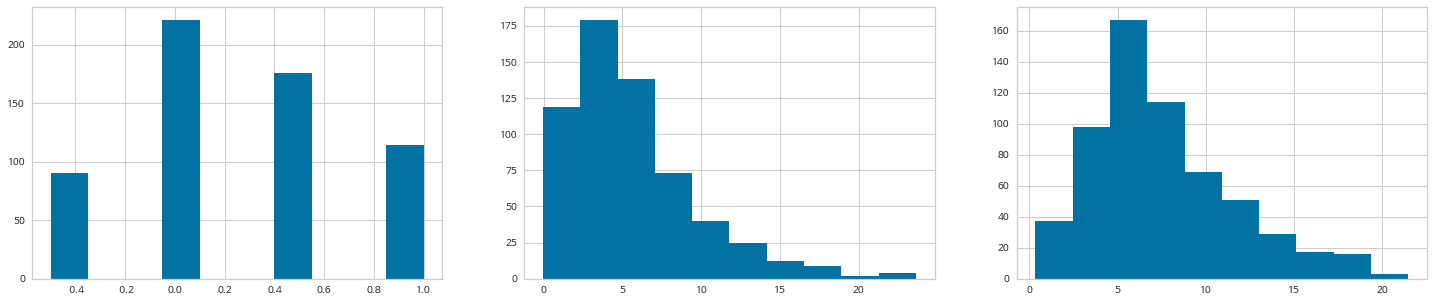

3
업종개수 large_cap medium_cap


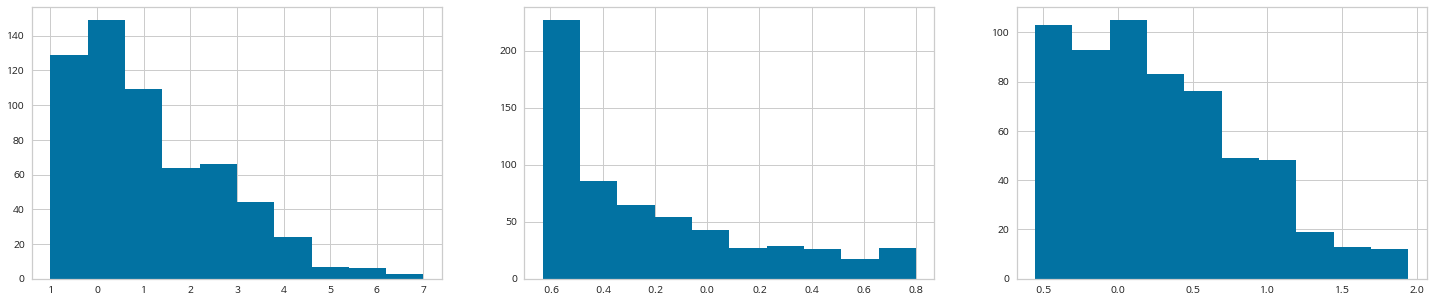

6
small_cap PER PBR


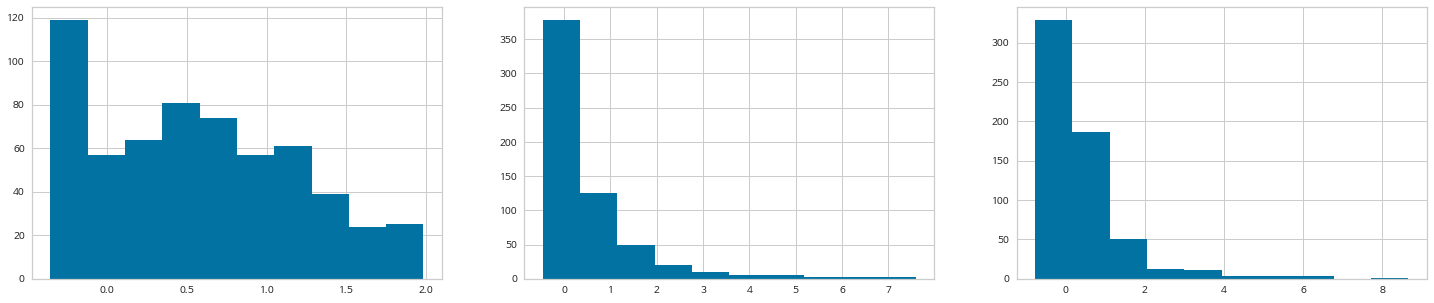

9
ROE EPS ATR_7


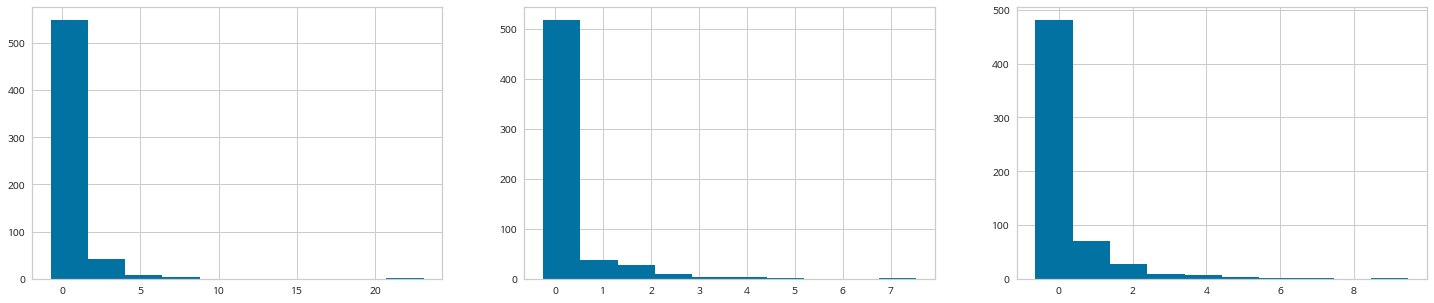

12


IndexError: ignored

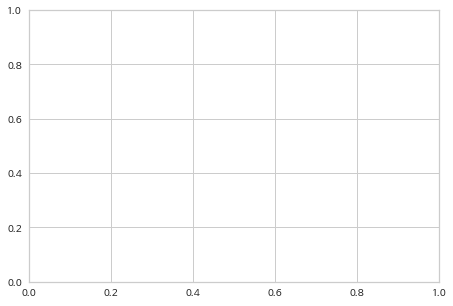

In [ ]:
temp_cluster = train_cluster[train_cluster.cluster == 0][['동일나이군구분코드', '총매수금액', '총매수수량', '업종개수', 'large_cap', 'medium_cap', 'small_cap', 'PER', 'PBR', 'ROE', 'EPS', 'ATR_7']].copy()

col_list = list(temp_cluster)
for i in range(0,13,3):
    print(i)
    plt.figure(figsize= (25,5))
    plt.subplot(1,3,1)
    plt.hist(temp_cluster[col_list[i]])
    plt.subplot(1,3,2)
    plt.hist(temp_cluster[col_list[i+1]])
    if i != 12:
        plt.subplot(1,3,3)
        plt.hist(temp_cluster[col_list[i+2]])
        print(col_list[i], col_list[i+1], col_list[i+2])
    else:
        print(col_list[i], col_list[i+1])       

    plt.show()

## 1번 군집 해석 - 0번 군집보다 조금 더 다양하게 많이 투자를 함. 돈도 좀 있고 위험을 즐기는 동학개미
- 사람수 130명 (4위)
- 30, 40대 다수 (50대 약간 많은 정도)
- 매수금액 많고 구매수량도 많음 (0번 군집보다 훨씬 우량 투자자)
- 업종은 다양하지 않은편 (0번 군집보다는 다양하게 투자)
- 중형, 소형주 투자 위주 (0번 군집보다 중소형 투자 정도가 강해짐)
- PBR, ROE 지표를 의식하는 편
- 변동성 높은 종목에 투자 (0번 군집보다 ATR 조금 상승)

0
동일나이군구분코드 총매수금액 총매수수량


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


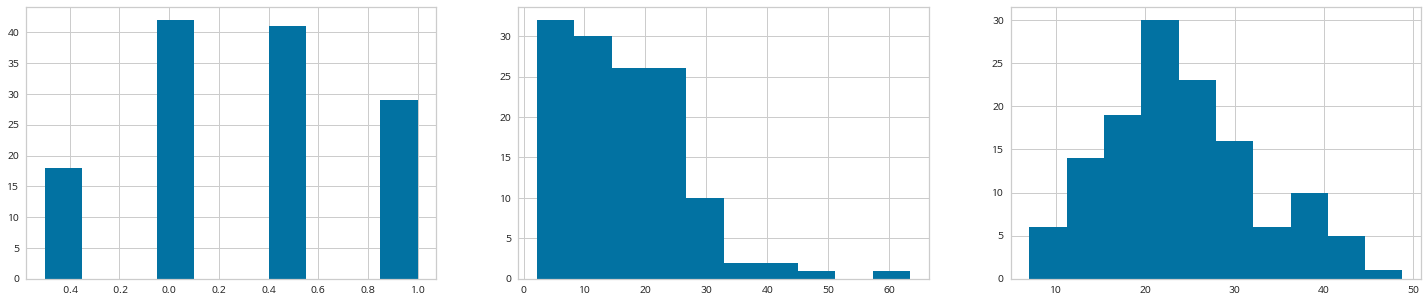

3
업종개수 large_cap medium_cap


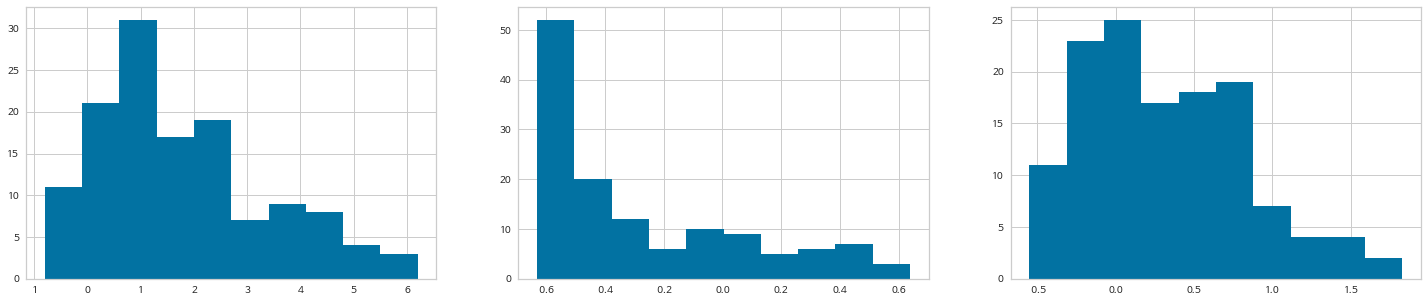

6
small_cap PER PBR


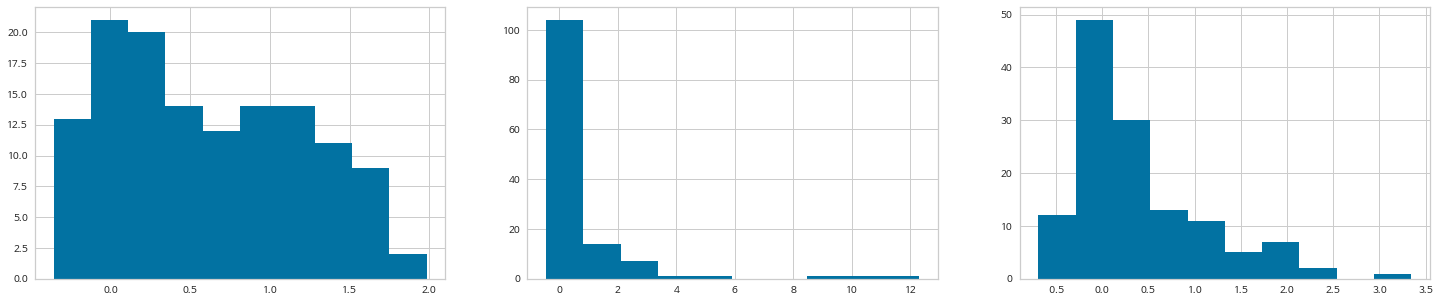

9
ROE EPS ATR_7


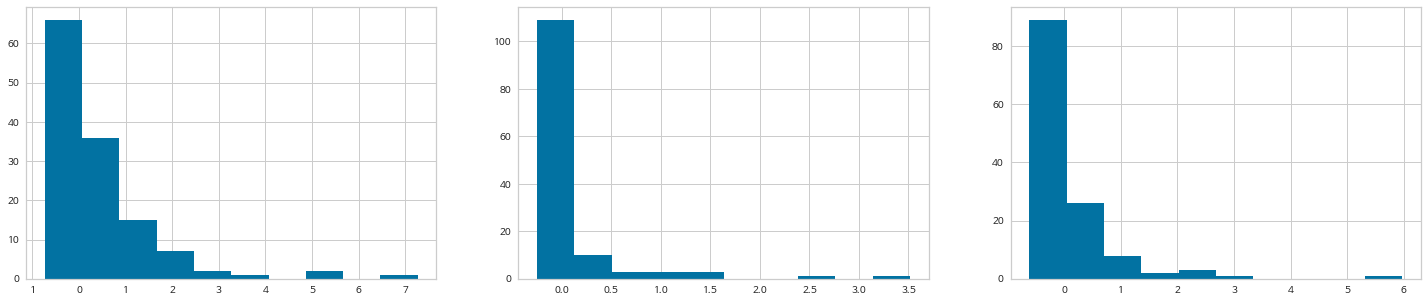

12


IndexError: ignored

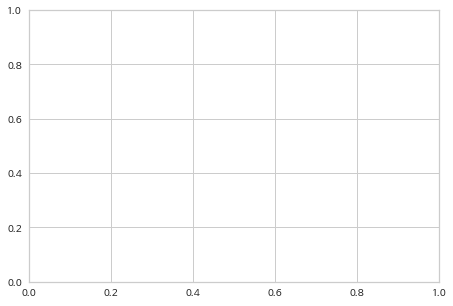

In [ ]:
temp_cluster = train_cluster[train_cluster.cluster == 1][['동일나이군구분코드', '총매수금액', '총매수수량', '업종개수', 'large_cap', 'medium_cap', 'small_cap', 'PER', 'PBR', 'ROE', 'EPS', 'ATR_7']].copy()

col_list = list(temp_cluster)
for i in range(0,13,3):
    print(i)
    plt.figure(figsize= (25,5))
    plt.subplot(1,3,1)
    plt.hist(temp_cluster[col_list[i]])
    plt.subplot(1,3,2)
    plt.hist(temp_cluster[col_list[i+1]])
    if i != 12:
        plt.subplot(1,3,3)
        plt.hist(temp_cluster[col_list[i+2]])
        print(col_list[i], col_list[i+1], col_list[i+2])
    else:
        print(col_list[i], col_list[i+1])       

    plt.show()

## 2번 군집 해석 -> 일반적인 동학개미투투자의 형태를 보임
- 사람수 6417명으로 1위 -> 동학개미 투자자 군집이라는 점 뒷받침
- 20, 30대 다수
- 매수금액 적고 구매수량도 적음 (0번 군집보다도 훨씬 소량 투자자 -> 지금까지 2<0<1 순서)
- 업종은 다양하지 않은편 (0번 군집보다도 다양하지 않게 투자 -> 2<0<1 순서)
- 대형, 중형주 투자 위주 (0번 군집보다 대형 투자 정도가 강해짐 -> 대형주 선호도 1<=0<2) 
- PER, ROE, ATR 지표를 의식하는 편 

0
동일나이군구분코드 총매수금액 총매수수량


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


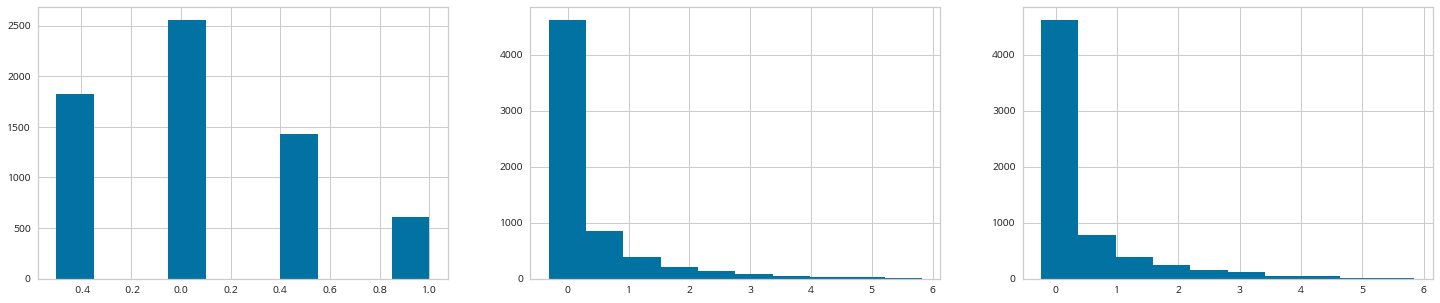

3
업종개수 large_cap medium_cap


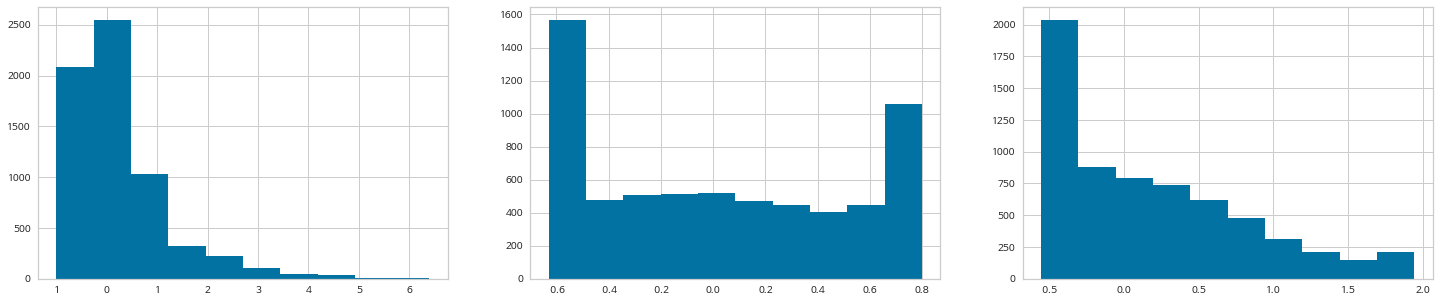

6
small_cap PER PBR


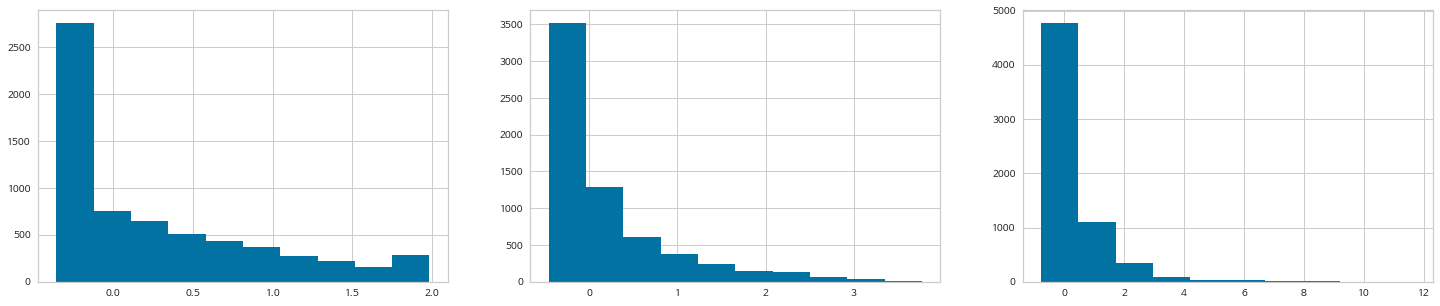

9
ROE EPS ATR_7


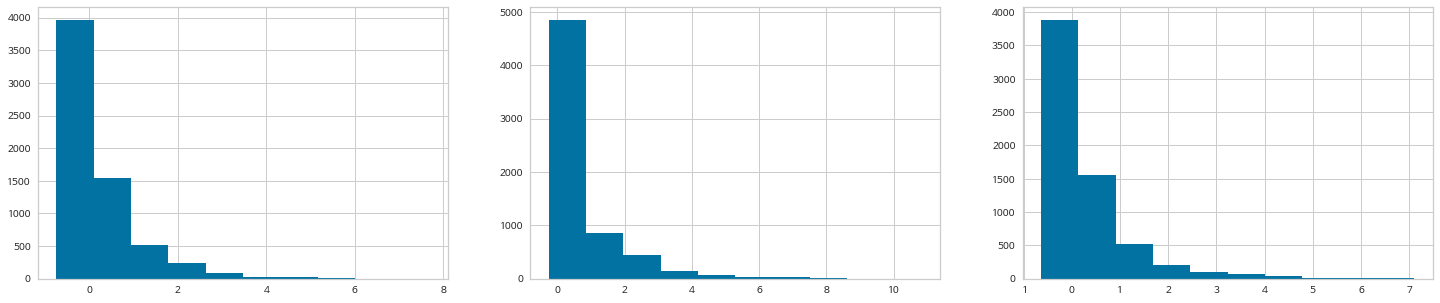

12


IndexError: ignored

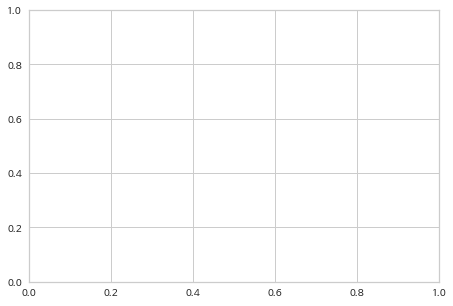

In [ ]:
temp_cluster = train_cluster[train_cluster.cluster == 2][['동일나이군구분코드', '총매수금액', '총매수수량', '업종개수', 'large_cap', 'medium_cap', 'small_cap', 'PER', 'PBR', 'ROE', 'EPS', 'ATR_7']].copy()

col_list = list(temp_cluster)
for i in range(0,13,3):
    print(i)
    plt.figure(figsize= (25,5))
    plt.subplot(1,3,1)
    plt.hist(temp_cluster[col_list[i]])
    plt.subplot(1,3,2)
    plt.hist(temp_cluster[col_list[i+1]])
    if i != 12:
        plt.subplot(1,3,3)
        plt.hist(temp_cluster[col_list[i+2]])
        print(col_list[i], col_list[i+1], col_list[i+2])
    else:
        print(col_list[i], col_list[i+1])       

    plt.show()

## 3번 군집 해석 -> 24명으로 가장 적은 군집 -> 대표성 없다고 봐야할듯.
- 군집수 24명 -> 대표성 있다고 보기 어려움
- 30대 다수, 나머지 나이대 비슷
- 매수금액 다양하고 구매수량 많음 (지금까지 2<0<1<3 순서)
- 업종은 다양한 편 ( 2<0<1<3 순서)
- 중형, 소형주 투자 위주 (대형주 선호도 3<1<=0<2) 
- PER, PBR, ROE, ATR등 여러 지표를 의식하는 편 

0
동일나이군구분코드 총매수금액 총매수수량


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


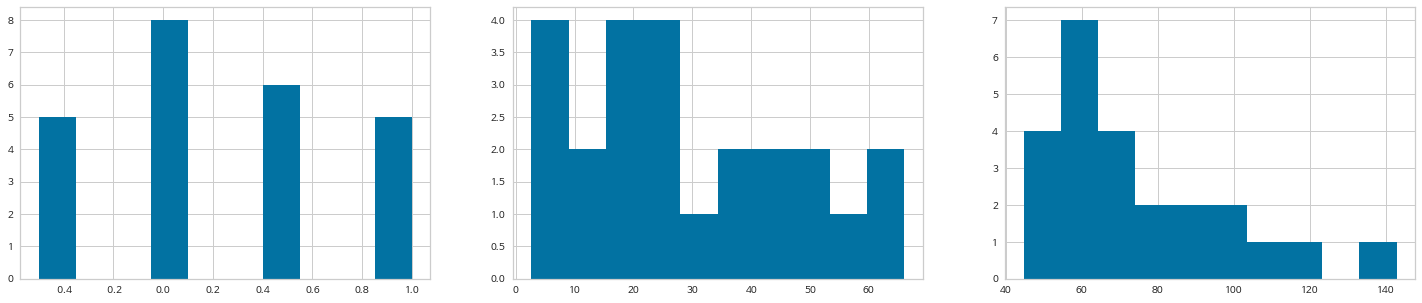

3
업종개수 large_cap medium_cap


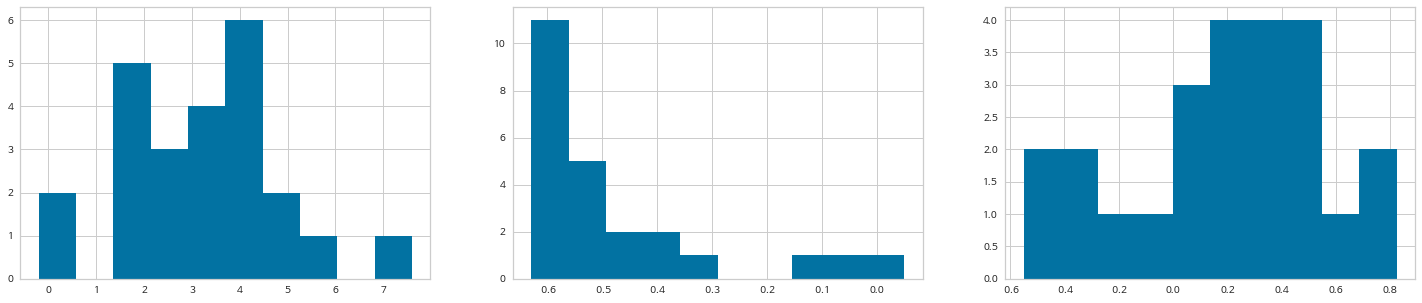

6
small_cap PER PBR


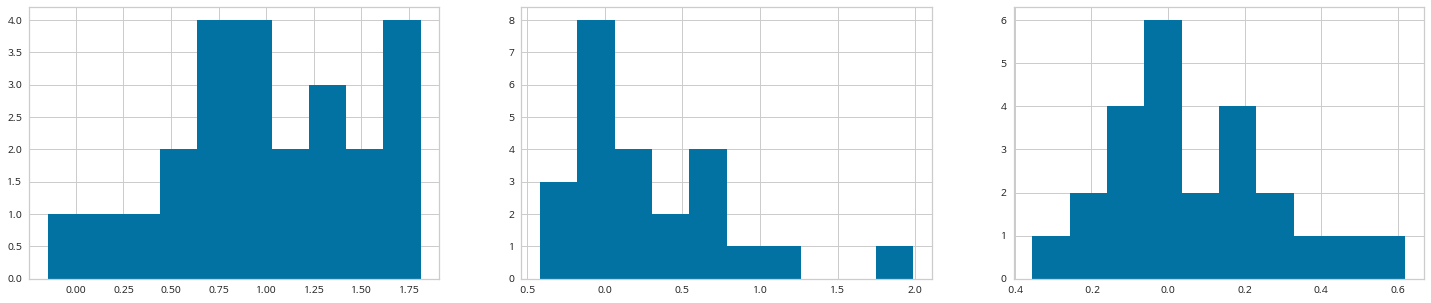

9
ROE EPS ATR_7


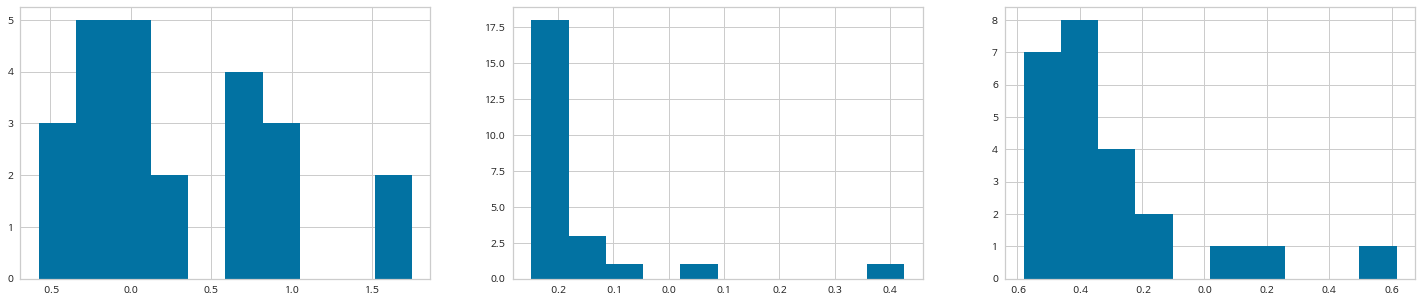

12


IndexError: ignored

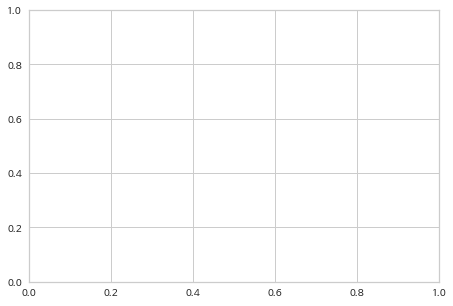

In [ ]:
temp_cluster = train_cluster[train_cluster.cluster == 3][['동일나이군구분코드', '총매수금액', '총매수수량', '업종개수', 'large_cap', 'medium_cap', 'small_cap', 'PER', 'PBR', 'ROE', 'EPS', 'ATR_7']].copy()

col_list = list(temp_cluster)
for i in range(0,13,3):
    print(i)
    plt.figure(figsize= (25,5))
    plt.subplot(1,3,1)
    plt.hist(temp_cluster[col_list[i]])
    plt.subplot(1,3,2)
    plt.hist(temp_cluster[col_list[i+1]])
    if i != 12:
        plt.subplot(1,3,3)
        plt.hist(temp_cluster[col_list[i+2]])
        print(col_list[i], col_list[i+1], col_list[i+2])
    else:
        print(col_list[i], col_list[i+1])       

    plt.show()

## 4번 군집 해석 -> 일반적인 동학개미 투자자인 2번 군집보다 훨씬 방어적인 투자자
- 군집 숫자 766명 (2위)
- 20대 30대 40대 다수, 50대 소수
- 매수금액 다양하지 않고 구매수량 적음 (지금까지 4<2<0<1<3 순서)
- 업종은 다양하지 않은 편 ( 4<2<0<1<3 순서)
- 대형주 투자 위주 (대형주 선호도 3<1<=0<2<4) 
- PBR 지표를 선호하고 그외 PER, ATR 추종하는 편

0
동일나이군구분코드 총매수금액 총매수수량


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


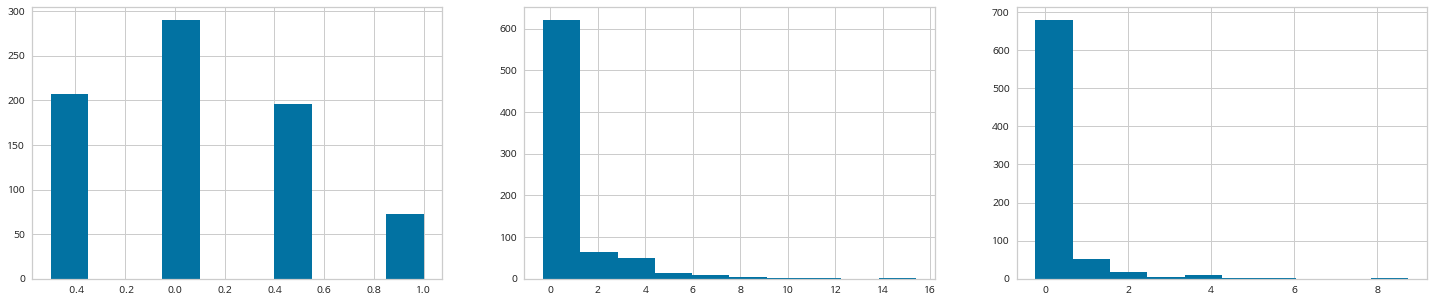

3
업종개수 large_cap medium_cap


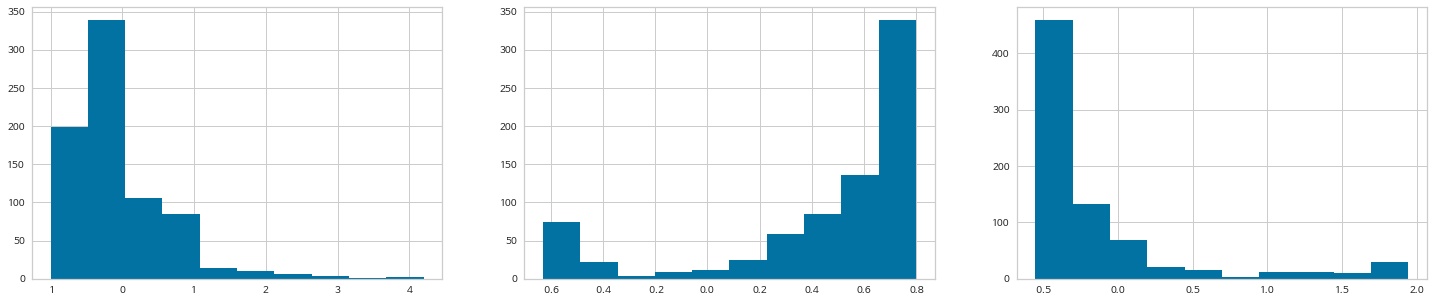

6
small_cap PER PBR


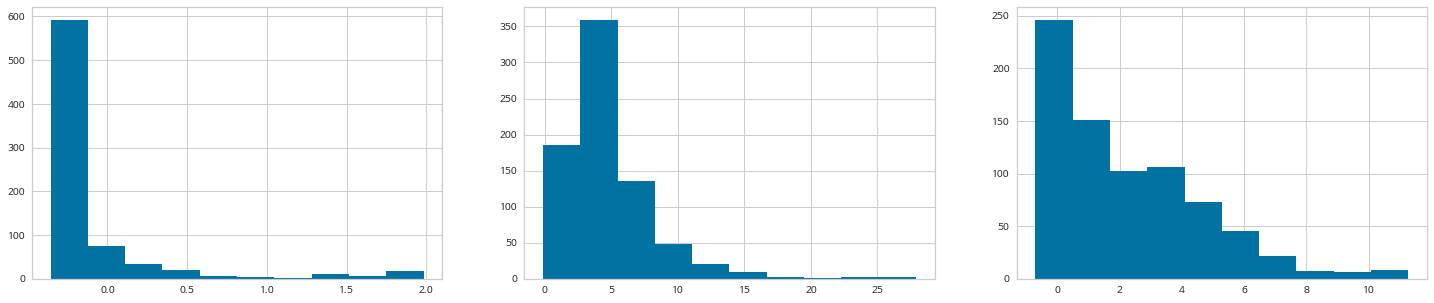

9
ROE EPS ATR_7


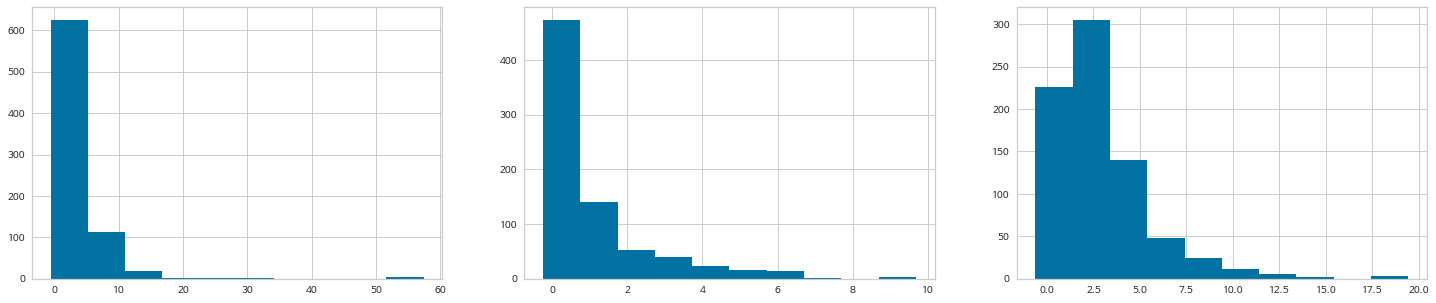

12


IndexError: ignored

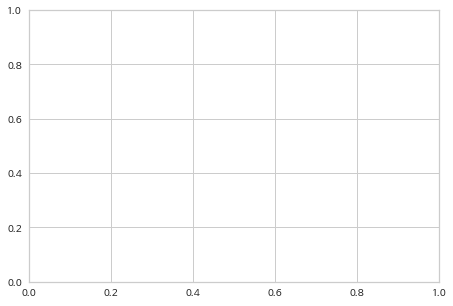

In [ ]:
temp_cluster = train_cluster[train_cluster.cluster == 4][['동일나이군구분코드', '총매수금액', '총매수수량', '업종개수', 'large_cap', 'medium_cap', 'small_cap', 'PER', 'PBR', 'ROE', 'EPS', 'ATR_7']].copy()

col_list = list(temp_cluster)
for i in range(0,13,3):
    print(i)
    plt.figure(figsize= (25,5))
    plt.subplot(1,3,1)
    plt.hist(temp_cluster[col_list[i]])
    plt.subplot(1,3,2)
    plt.hist(temp_cluster[col_list[i+1]])
    if i != 12:
        plt.subplot(1,3,3)
        plt.hist(temp_cluster[col_list[i+2]])
        print(col_list[i], col_list[i+1], col_list[i+2])
    else:
        print(col_list[i], col_list[i+1])       

    plt.show()

In [ ]:
train_cluster.to_csv(path + '클러스터링_시도1.csv', index=False)

In [ ]:
train_cluster.cluster.value_counts()

2    6417
4     766
0     601
1     130
3      24
Name: cluster, dtype: int64

In [ ]:
train_cluster

,동일나이군구분코드,총매수금액,총매수수량,업종개수,large_cap,medium_cap,small_cap,large_cap_period,PER,PBR,ROE,EPS,ATR_7,cluster
0,0.0,-0.188454,-0.220015,-0.8,0.798295,-0.550775,-0.356546,-0.391667,-0.137600,-0.399572,1.284474,4.487079,2.107561,2
1,0.0,1.012451,0.214668,-0.6,0.520765,-0.066435,-0.356546,-0.386667,4.516943,3.510591,0.905693,0.058723,2.319570,4
2,1.0,-0.298310,-0.216960,-1.0,-0.629170,1.940399,-0.356546,-0.666667,-0.397684,-0.403039,-0.469574,1.924817,-0.440116,2
3,0.0,1.202118,3.247517,1.8,-0.629170,0.539688,0.959189,-0.666667,0.397516,-0.348721,1.578465,-0.148041,-0.462189,2
4,-0.5,-0.229829,1.138273,0.0,-0.165281,-0.550775,1.223045,-0.666667,-0.335217,-0.451078,-0.404407,0.000165,-0.585511,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7933,0.0,0.207308,3.671505,-0.2,0.261436,-0.152156,0.149091,0.283333,-0.028248,-0.551939,1.174691,0.358817,0.316181,2
7934,-0.5,6.608258,3.763178,0.0,-0.418166,-0.199783,1.307901,0.233333,-0.056973,0.632808,-0.211370,-0.200899,0.325801,0
7935,-0.5,-0.273831,-0.227655,-0.8,0.690608,-0.362841,-0.356546,0.197470,0.131442,-0.413144,1.513316,2.317100,1.925226,2
7936,0.0,-0.256647,-0.223835,-0.6,0.611933,-0.225541,-0.356546,-0.216667,-0.232764,-0.340779,0.234008,2.383798,0.863129,2
